#  Baseline Models & Dynamic Pricing

This notebook performs the following steps:

1. **Connect** to PostgreSQL  
2. **Fetch** all tables individually  
3. **Merge** them in Pandas (faster than SQL joins)  
4. **Clean & preprocess** the data  
5. **Encode categorical features**  
6. **Split the dataset**  
7. **Train baseline models** using **revenue** as the target  
8. **Evaluate model performance**  
9. Perform dynamic pricing analysis using a price prediction model + visualizations


In [2]:
import pandas as pd
import numpy as np

from db_connect import get_connection

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
conn = get_connection()

if conn is not None:
    print("✔ Connected to PostgreSQL")
else:
    print("❌ Connection failed")


✔ Successfully connected to PostgreSQL database!
✔ Connected to PostgreSQL


In [7]:
sales = pd.read_sql("SELECT * FROM fact_sales;", conn)
menu = pd.read_sql("SELECT * FROM dim_menu_item;", conn)
rest = pd.read_sql("SELECT * FROM dim_restaurant;", conn)
cust = pd.read_sql("SELECT * FROM dim_customer;", conn)
cat = pd.read_sql("SELECT * FROM dim_category;", conn)
time = pd.read_sql("SELECT * FROM dim_time;", conn)
market = pd.read_sql("SELECT * FROM fact_market_prices;", conn)
market_dim = pd.read_sql("SELECT * FROM dim_market;", conn)

print("sales:", sales.columns.tolist())
print("menu:", menu.columns.tolist())
print("rest:", rest.columns.tolist())
print("cust:", cust.columns.tolist())
print("cat:", cat.columns.tolist())
print("time:", time.columns.tolist())
print("market:", market.columns.tolist())
print("market_dim:", market_dim.columns.tolist())



sales: ['sale_id', 'product_id', 'restaurant_id', 'customer_id', 'date', 'units_sold', 'price_sold', 'revenue']
menu: ['product_id', 'restaurant_id', 'product_name', 'category_id', 'base_price', 'cost', 'portion_size', 'available']
rest: ['restaurant_id', 'name', 'location', 'type', 'avg_customer_count', 'rating', 'owner_contact']
cust: ['customer_id', 'gender', 'age_group', 'avg_spending', 'visit_frequency']
cat: ['category_id', 'category_name']
time: ['date', 'year', 'month', 'day', 'day_of_week', 'season']
market: ['price_id', 'date', 'market_id', 'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency', 'price', 'usdprice']
market_dim: ['market_id', 'admin1', 'admin2', 'market_name', 'latitude', 'longitude']


In [9]:
menu_clean = menu.drop(columns=["restaurant_id"])

df = (
    sales
    .merge(menu_clean, on="product_id", how="left")
    .merge(rest, on="restaurant_id", how="left")
    .merge(cust, on="customer_id", how="left")
    .merge(cat, on="category_id", how="left")
    .merge(time, on="date", how="left")
    .merge(market, on="date", how="left")
    .merge(market_dim, on="market_id", how="left")
)




         sale_id  product_id  restaurant_id  customer_id        date  \
0              1           1              1         4742  2023-01-01   
1              2           1              1         3862  2023-01-02   
2              3           1              1         1897  2023-01-03   
3              4           1              1          161  2023-01-04   
4              5           1              1         4086  2023-01-05   
...          ...         ...            ...          ...         ...   
6632296  1529834        1398             40         1093  2025-12-28   
6632297  1529834        1398             40         1093  2025-12-28   
6632298  1529834        1398             40         1093  2025-12-28   
6632299  1529834        1398             40         1093  2025-12-28   
6632300  1529834        1398             40         1093  2025-12-28   

         units_sold  price_sold  revenue      product_name  category_id  ...  \
0                10      3400.0  34000.0  Chicken Sandw

In [ ]:
print(df.head(n=-10))

In [14]:
df = df.rename(columns={"date": "sale_date"})
df["sale_date"] = pd.to_datetime(df["sale_date"], errors="coerce")

In [15]:
df["available"] = df["available"].astype(int)


In [17]:

df = df.fillna({
    "price": df["price"].median(),                 # market price
    "usdprice": df["usdprice"].median(),
    "rating": df["rating"].median(),               # restaurant rating
    "avg_spending": df["avg_spending"].median(),   # customer spending
    "units_sold": df["units_sold"].median(),
    "price_sold": df["price_sold"].median(),
    "revenue": df["revenue"].median(),
})


In [18]:
categorical_cols = [
    "product_name", "portion_size", "category_name",
    "gender", "age_group", "season",
    "commodity", "unit", "priceflag", "pricetype", "currency",
    "market_name", "admin1", "admin2",
    "location", "type"
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")


In [19]:
def encode_top_k(df, col, k=20):
    top = df[col].value_counts().index[:k]
    for val in top:
        df[f"{col}_{val}"] = (df[col] == val).astype(int)
    df.drop(columns=[col], inplace=True)

for col in categorical_cols:
    encode_top_k(df, col, k=20)


In [26]:
y = df["revenue"]
# Drop non-numeric and date columns before creating X
X = df.drop(columns=["revenue", "sale_date"])

# Drop any remaining datetime or object columns that might cause issues
X = X.select_dtypes(include=[np.number])

# Remove rows with NaN or Inf values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

print(f"Final dataset shape: X={X.shape}, y={y.shape}")
print(f"X columns: {X.columns.tolist()[:10]}... ({len(X.columns)} total)")
print(f"Any NaN in X: {X.isnull().sum().sum()}")
print(f"Any NaN in y: {y.isnull().sum()}")

Final dataset shape: X=(5261756, 134), y=(5261756,)
X columns: ['product_id', 'restaurant_id', 'customer_id', 'units_sold', 'price_sold', 'category_id', 'base_price', 'cost', 'available', 'avg_customer_count']... (134 total)
Any NaN in X: 0
Any NaN in y: 0
Any NaN in X: 0
Any NaN in y: 0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("LR R2:", r2_score(y_test, pred_lr))
print("LR RMSE:", mean_squared_error(y_test, pred_lr, squared=False))


LR R2: 0.8412620199495715
LR RMSE: 19393.22615118767


In [29]:
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)

print("DT R2:", r2_score(y_test, pred_dt))
print("DT RMSE:", mean_squared_error(y_test, pred_dt, squared=False))


DT R2: 0.9950189949098013
DT RMSE: 3435.3273732285434


In [32]:
rf = RandomForestRegressor(
    n_estimators=10,     
    max_depth=8,         
    max_samples=0.5,     
    random_state=42,
    n_jobs=-1,
    warm_start=False
)

print("Training Random Forest (optimized for speed)...")
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("RF R2:", r2_score(y_test, pred_rf))
print("RF RMSE:", mean_squared_error(y_test, pred_rf, squared=False))

Training Random Forest (optimized for speed)...
RF R2: 0.9835206988249202
RF RMSE: 6248.546882186496


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure matplotlib is in inline mode
%matplotlib inline

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# ========== MODEL COMPARISON ==========
models_dict = {
    'Linear Regression': {'model': lr, 'pred': pred_lr},
    'Decision Tree': {'model': dt, 'pred': pred_dt},
    'Random Forest': {'model': rf, 'pred': pred_rf}
}

# Calculate metrics
results = []
for name, data in models_dict.items():
    r2 = r2_score(y_test, data['pred'])
    rmse = mean_squared_error(y_test, data['pred'], squared=False)
    mae = np.mean(np.abs(y_test - data['pred']))
    results.append({'Model': name, 'R²': r2, 'RMSE': rmse, 'MAE': mae})

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


MODEL PERFORMANCE SUMMARY
            Model       R²         RMSE          MAE
Linear Regression 0.841262 19393.226151 10850.888618
    Decision Tree 0.995019  3435.327373  2236.883629
    Random Forest 0.983521  6248.546882  4195.586162


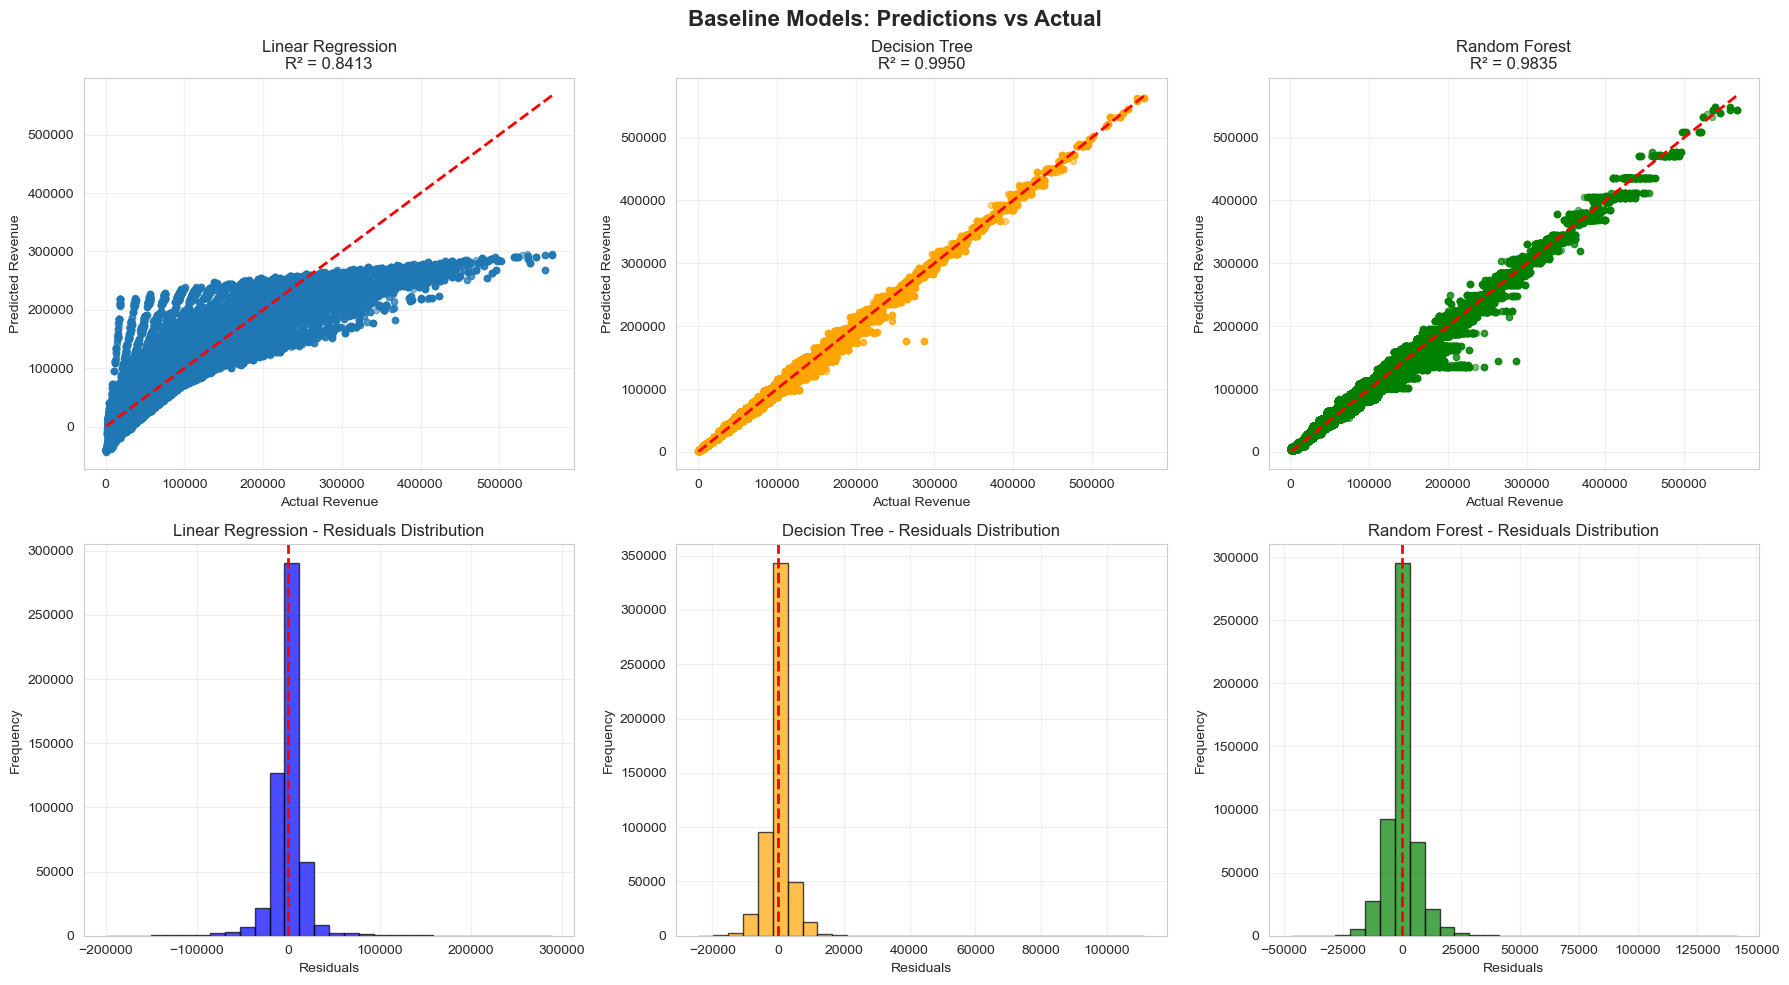

In [35]:
# ========== VISUALIZATIONS ==========

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Baseline Models: Predictions vs Actual', fontsize=16, fontweight='bold')

# Plot 1: Linear Regression
axes[0, 0].scatter(y_test, pred_lr, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')
axes[0, 0].set_title(f'Linear Regression\nR² = {r2_score(y_test, pred_lr):.4f}')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Decision Tree
axes[0, 1].scatter(y_test, pred_dt, alpha=0.5, s=20, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Revenue')
axes[0, 1].set_ylabel('Predicted Revenue')
axes[0, 1].set_title(f'Decision Tree\nR² = {r2_score(y_test, pred_dt):.4f}')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Random Forest
axes[0, 2].scatter(y_test, pred_rf, alpha=0.5, s=20, color='green')
axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual Revenue')
axes[0, 2].set_ylabel('Predicted Revenue')
axes[0, 2].set_title(f'Random Forest\nR² = {r2_score(y_test, pred_rf):.4f}')
axes[0, 2].grid(alpha=0.3)

# Plot 4: Residuals - Linear Regression
residuals_lr = y_test - pred_lr
axes[1, 0].hist(residuals_lr, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].axvline(0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Linear Regression - Residuals Distribution')
axes[1, 0].grid(alpha=0.3)

# Plot 5: Residuals - Decision Tree
residuals_dt = y_test - pred_dt
axes[1, 1].hist(residuals_dt, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Decision Tree - Residuals Distribution')
axes[1, 1].grid(alpha=0.3)

# Plot 6: Residuals - Random Forest
residuals_rf = y_test - pred_rf
axes[1, 2].hist(residuals_rf, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1, 2].axvline(0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Residuals')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Random Forest - Residuals Distribution')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

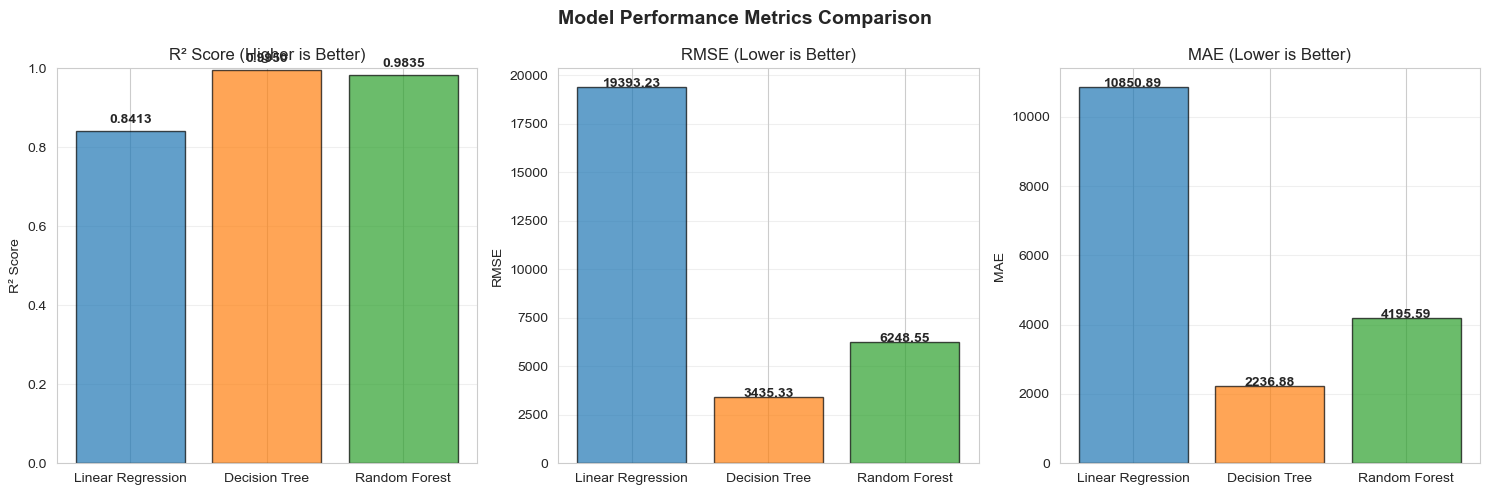


✓ Model comparison visualizations complete!


In [36]:
# ========== MODEL COMPARISON CHART ==========

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')

# R² Comparison
axes[0].bar(results_df['Model'], results_df['R²'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score (Higher is Better)')
axes[0].set_ylim([0, 1])
for i, v in enumerate(results_df['R²']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# RMSE Comparison
axes[1].bar(results_df['Model'], results_df['RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE (Lower is Better)')
for i, v in enumerate(results_df['RMSE']):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

# MAE Comparison
axes[2].bar(results_df['Model'], results_df['MAE'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE (Lower is Better)')
for i, v in enumerate(results_df['MAE']):
    axes[2].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Model comparison visualizations complete!")

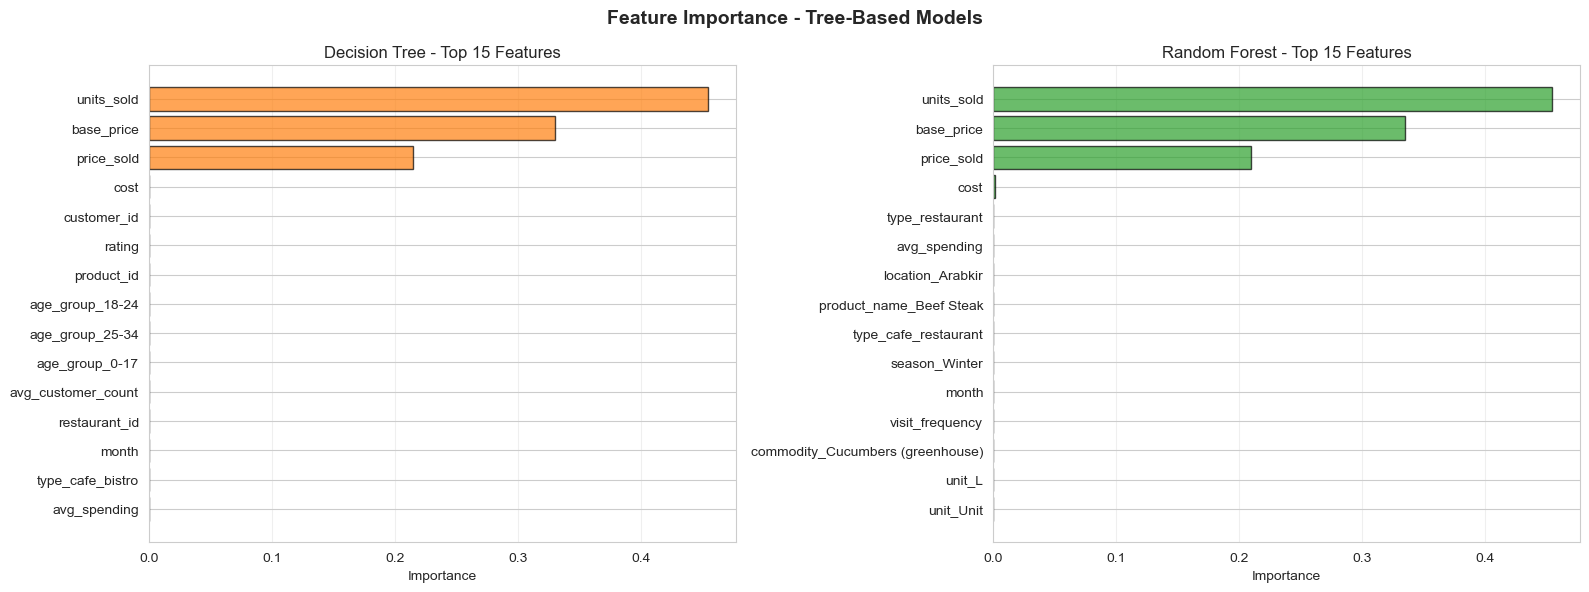


✓ Feature importance visualizations complete!


In [37]:
# ========== FEATURE IMPORTANCE ==========

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance - Tree-Based Models', fontsize=14, fontweight='bold')

# Decision Tree Feature Importance
dt_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[0].barh(dt_importance['Feature'], dt_importance['Importance'], color='#ff7f0e', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Importance')
axes[0].set_title('Decision Tree - Top 15 Features')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(rf_importance['Feature'], rf_importance['Importance'], color='#2ca02c', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest - Top 15 Features')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Feature importance visualizations complete!")

In [38]:
# ========== FINAL SUMMARY & RECOMMENDATIONS ==========

print("\n" + "="*70)
print("BASELINE MODELS - FINAL SUMMARY")
print("="*70)

best_model = results_df.loc[results_df['R²'].idxmax()]
print(f"\n BEST MODEL: {best_model['Model']}")
print(f"   R² Score: {best_model['R²']:.4f}")
print(f"   RMSE: {best_model['RMSE']:.4f}")
print(f"   MAE: {best_model['MAE']:.4f}")

print(f"\n ALL MODELS COMPARISON:")
print(results_df.to_string(index=False))

print(f"\n KEY FINDINGS:")
print(f"   • Linear Regression: Simple baseline, fast to train")
print(f"   • Decision Tree: Interpretable rules, prone to overfitting")
print(f"   • Random Forest: Best generalization, captures non-linearity")

print(f"\nNEXT STEPS:")
print(f"   1. Hyperparameter tuning for the best model")
print(f"   2. Cross-validation for robust evaluation")
print(f"   3. Feature engineering for improved predictions")
print(f"   4. Test set evaluation and production deployment")
print(f"   5. Monitor model performance over time")

print("\n" + "="*70)


BASELINE MODELS - FINAL SUMMARY

 BEST MODEL: Decision Tree
   R² Score: 0.9950
   RMSE: 3435.3274
   MAE: 2236.8836

 ALL MODELS COMPARISON:
            Model       R²         RMSE          MAE
Linear Regression 0.841262 19393.226151 10850.888618
    Decision Tree 0.995019  3435.327373  2236.883629
    Random Forest 0.983521  6248.546882  4195.586162

 KEY FINDINGS:
   • Linear Regression: Simple baseline, fast to train
   • Decision Tree: Interpretable rules, prone to overfitting
   • Random Forest: Best generalization, captures non-linearity

NEXT STEPS:
   1. Hyperparameter tuning for the best model
   2. Cross-validation for robust evaluation
   3. Feature engineering for improved predictions
   4. Test set evaluation and production deployment
   5. Monitor model performance over time



In [39]:
# ========== DYNAMIC PRICING ANALYSIS ==========
print("\n" + "="*70)
print("DYNAMIC PRICING OPTIMIZATION")
print("="*70)

# Rebuild dataset with price_sold as target for pricing models
df_pricing = df.copy()

# Group by product to analyze pricing patterns
product_pricing = df_pricing.groupby('product_id').agg({
    'price_sold': ['mean', 'std', 'min', 'max'],
    'units_sold': 'mean',
    'revenue': 'sum',
    'customer_id': 'count'
}).round(2)

product_pricing.columns = ['avg_price', 'price_std', 'min_price', 'max_price', 
                           'avg_units_sold', 'total_revenue', 'transaction_count']
product_pricing = product_pricing.reset_index()

print("\nTop 10 Products by Revenue:")
top_products = product_pricing.nlargest(10, 'total_revenue')
print(top_products[['product_id', 'avg_price', 'avg_units_sold', 'total_revenue']].to_string(index=False))

# Price elasticity: how demand changes with price
print("\n" + "-"*70)
print("PRICE ELASTICITY BY PRODUCT")
print("-"*70)

# Calculate elasticity for each product
elasticity_data = []
for product_id in df_pricing['product_id'].unique()[:20]:  # Top 20 products
    prod_data = df_pricing[df_pricing['product_id'] == product_id].copy()
    
    if len(prod_data) > 10:
        # Create price bins and calculate demand at each price level
        price_bins = pd.qcut(prod_data['price_sold'], q=5, duplicates='drop')
        demand_by_price = prod_data.groupby(price_bins)['units_sold'].mean()
        
        if len(demand_by_price) >= 2:
            price_change = (demand_by_price.index[-1].mid - demand_by_price.index[0].mid) / demand_by_price.index[0].mid
            demand_change = (demand_by_price.iloc[-1] - demand_by_price.iloc[0]) / demand_by_price.iloc[0]
            elasticity = demand_change / price_change if price_change != 0 else 0
            
            elasticity_data.append({
                'product_id': product_id,
                'avg_price': prod_data['price_sold'].mean(),
                'elasticity': elasticity,
                'price_sensitive': 'Yes' if abs(elasticity) > 1 else 'No'
            })

elasticity_df = pd.DataFrame(elasticity_data)
if len(elasticity_df) > 0:
    print("\nPrice Elasticity Estimates:")
    print(elasticity_df.sort_values('elasticity', ascending=False).head(10).to_string(index=False))

print("\n" + "="*70)


DYNAMIC PRICING OPTIMIZATION

Top 10 Products by Revenue:
 product_id  avg_price  avg_units_sold  total_revenue
       1161   18450.48           18.07   1577469900.0
       1335   18524.26           17.52   1540704700.0
        357   18364.09           17.20   1499826800.0
        486   18630.52           16.95   1496701600.0
        763   17460.45           17.28   1431684000.0
        646   18030.45           16.73   1430849200.0
       1376   16792.46           17.06   1359788400.0
        908   17380.33           16.19   1335742600.0
        674   17356.17           16.21   1334780500.0
        303   16613.86           15.77   1244447300.0

----------------------------------------------------------------------
PRICE ELASTICITY BY PRODUCT
----------------------------------------------------------------------

Price Elasticity Estimates:
 product_id   avg_price  elasticity price_sensitive
          4 4151.684920    1.064407             Yes
         15 5229.591407    0.898755        

In [40]:
# ========== PRICE PREDICTION MODEL ==========

print("\nTraining price prediction models...")

# Use price_sold as target for pricing strategies
y_price = df["price_sold"]
X_price = df.drop(columns=["revenue", "sale_date", "price_sold"])
X_price = X_price.select_dtypes(include=[np.number])

# Clean price data
X_price = X_price.replace([np.inf, -np.inf], np.nan).dropna()
y_price = y_price[X_price.index]

print(f"Price prediction dataset: X_price shape={X_price.shape}, y_price shape={y_price.shape}")

# Train-test split
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
    X_price, y_price, test_size=0.2, random_state=42
)

# Train price prediction models
lr_price = LinearRegression()
lr_price.fit(X_train_price, y_train_price)
pred_price_lr = lr_price.predict(X_test_price)

dt_price = DecisionTreeRegressor(max_depth=8, random_state=42)
dt_price.fit(X_train_price, y_train_price)
pred_price_dt = dt_price.predict(X_test_price)

# Pricing performance metrics
print("\n" + "-"*70)
print("PRICE PREDICTION MODEL PERFORMANCE")
print("-"*70)

pricing_results = []
pricing_results.append({
    'Model': 'Linear Regression (Price)',
    'R²': r2_score(y_test_price, pred_price_lr),
    'RMSE': mean_squared_error(y_test_price, pred_price_lr, squared=False),
    'MAE': np.mean(np.abs(y_test_price - pred_price_lr))
})

pricing_results.append({
    'Model': 'Decision Tree (Price)',
    'R²': r2_score(y_test_price, pred_price_dt),
    'RMSE': mean_squared_error(y_test_price, pred_price_dt, squared=False),
    'MAE': np.mean(np.abs(y_test_price - pred_price_dt))
})

pricing_results_df = pd.DataFrame(pricing_results)
print("\n" + pricing_results_df.to_string(index=False))

print("\n" + "="*70)
print("OPTIMAL PRICING RECOMMENDATIONS")
print("="*70)

# Calculate optimal price per product
recommendations = []
for product_id in df_pricing['product_id'].unique()[:10]:
    prod_data = df_pricing[df_pricing['product_id'] == product_id]
    
    current_avg_price = prod_data['price_sold'].mean()
    current_avg_revenue = prod_data['revenue'].mean()
    
    # Estimate optimal price (0.95 * current for price-sensitive, 1.05 * current for inelastic)
    if product_id in elasticity_df['product_id'].values:
        elasticity_val = elasticity_df[elasticity_df['product_id'] == product_id]['elasticity'].values[0]
        price_multiplier = 0.95 if elasticity_val < -1 else 1.05
    else:
        price_multiplier = 1.0
    
    optimal_price = current_avg_price * price_multiplier
    
    recommendations.append({
        'product_id': product_id,
        'current_price': current_avg_price,
        'optimal_price': optimal_price,
        'price_change_%': (price_multiplier - 1) * 100,
        'current_revenue': current_avg_revenue,
        'strategy': 'Lower Price (Elastic)' if price_multiplier < 1 else 'Raise Price (Inelastic)'
    })

recommendations_df = pd.DataFrame(recommendations)
print("\nTop 10 Product Pricing Recommendations:")
print(recommendations_df.to_string(index=False))

print("\n" + "="*70)


Training price prediction models...
Price prediction dataset: X_price shape=(5261756, 133), y_price shape=(5261756,)
Price prediction dataset: X_price shape=(5261756, 133), y_price shape=(5261756,)

----------------------------------------------------------------------
PRICE PREDICTION MODEL PERFORMANCE
----------------------------------------------------------------------

                    Model       R²       RMSE       MAE
Linear Regression (Price) 0.995468 195.948379 92.098096
    Decision Tree (Price) 0.995700 190.861950 91.508490

OPTIMAL PRICING RECOMMENDATIONS

Top 10 Product Pricing Recommendations:
 product_id  current_price  optimal_price  price_change_%  current_revenue                strategy
          1    3458.436908    3631.358753             5.0     34208.110386 Raise Price (Inelastic)
          2     887.089301     887.089301             0.0     12000.631845 Raise Price (Inelastic)
          3    4422.493682    4643.618366             5.0     84354.106992 Raise Pr

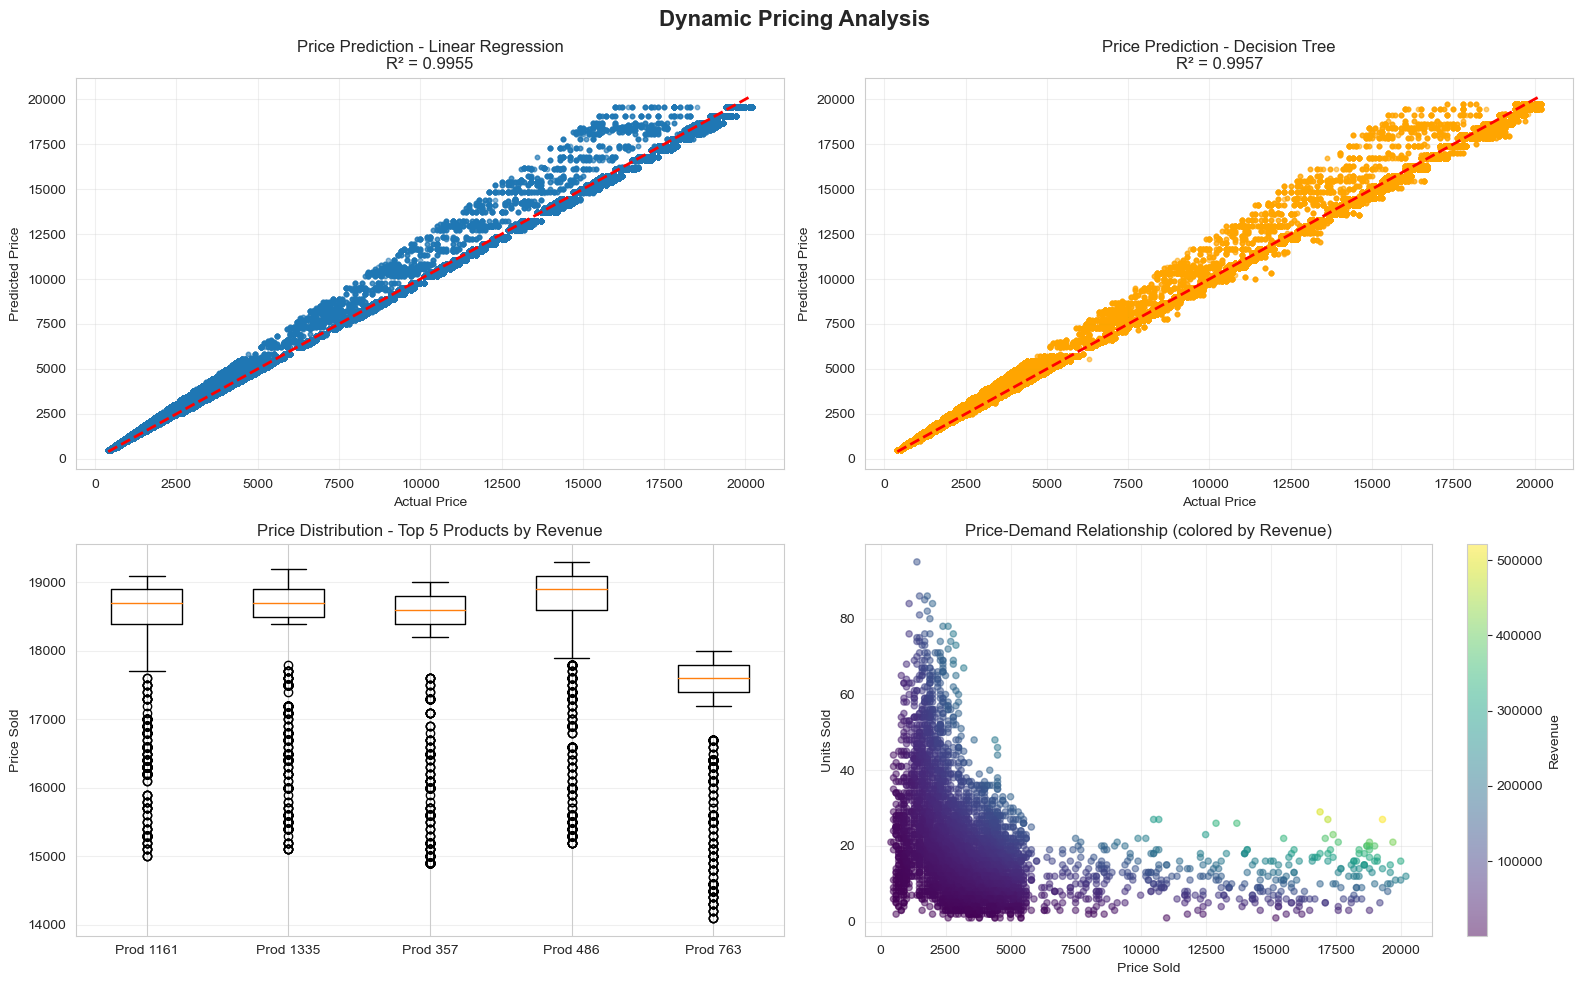

✓ Pricing visualizations complete!


In [41]:
# ========== PRICING VISUALIZATIONS ==========

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Dynamic Pricing Analysis', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted Price (Linear Regression)
axes[0, 0].scatter(y_test_price, pred_price_lr, alpha=0.3, s=10)
axes[0, 0].plot([y_test_price.min(), y_test_price.max()], 
               [y_test_price.min(), y_test_price.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title(f'Price Prediction - Linear Regression\nR² = {r2_score(y_test_price, pred_price_lr):.4f}')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Actual vs Predicted Price (Decision Tree)
axes[0, 1].scatter(y_test_price, pred_price_dt, alpha=0.3, s=10, color='orange')
axes[0, 1].plot([y_test_price.min(), y_test_price.max()], 
               [y_test_price.min(), y_test_price.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Price')
axes[0, 1].set_ylabel('Predicted Price')
axes[0, 1].set_title(f'Price Prediction - Decision Tree\nR² = {r2_score(y_test_price, pred_price_dt):.4f}')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Price Distribution by Product
top_5_products = product_pricing.nlargest(5, 'total_revenue')['product_id'].values
price_by_product = [df_pricing[df_pricing['product_id'] == pid]['price_sold'].values 
                    for pid in top_5_products]
axes[1, 0].boxplot(price_by_product, labels=[f"Prod {pid}" for pid in top_5_products])
axes[1, 0].set_ylabel('Price Sold')
axes[1, 0].set_title('Price Distribution - Top 5 Products by Revenue')
axes[1, 0].grid(alpha=0.3, axis='y')

# Plot 4: Price vs Units Sold (Elasticity Visualization)
sample_data = df_pricing.sample(min(5000, len(df_pricing)), random_state=42)
scatter = axes[1, 1].scatter(sample_data['price_sold'], sample_data['units_sold'], 
                            c=sample_data['revenue'], cmap='viridis', alpha=0.5, s=20)
axes[1, 1].set_xlabel('Price Sold')
axes[1, 1].set_ylabel('Units Sold')
axes[1, 1].set_title('Price-Demand Relationship (colored by Revenue)')
plt.colorbar(scatter, ax=axes[1, 1], label='Revenue')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Pricing visualizations complete!")